In [1]:
import numpy as np
from utilities import prepare_set
import matplotlib.pyplot as plt

from time import time

In [5]:
X_train, y_train, X_test, y_test = prepare_set('../data/D0_set_weighted.npy', True)

In [7]:
X_train.shape

(63180, 9)

In [3]:
# sb_big_ratio=True zwraca roporcej sygnału do tła na opziomie 1:350, zamiast 1:2
X_train_350, y_train_350, X_test_350, y_test_350 = prepare_set('../data/D0_set_weighted.npy', sb_big_ratio=True)

>S - ratio of # of classified signal (1) to # of counted signal in X_test  
B - ratio of # of classified background (0) to # of counted background in y_test

## ML model

In [14]:
def eff_signal(clf, X, y):
    '''How much of signal is classified as signal.'''
    test_count = 0
    fit_count = 0
    prediction = clf.predict(X[:testing_samples])
    for i in range(testing_samples):
        if y[i] == 1:
            test_count += 1
            if prediction[i] == 1:
                fit_count += 1
                
    print('signal count:', test_count)
    print('signal predict:', fit_count)
    return fit_count

def eff_background(clf, X, y):
    '''How much of background is classified as background.'''
    test_count = 0
    fit_count = 0
    prediction = clf.predict(X[:testing_samples])
    for i in range(testing_samples):
        if y[i] == 0:
            test_count += 1
            if prediction[i] == 0:
                fit_count += 1
    
    print(fit_count)
    print(test_count)
    return (1 - fit_count / test_count) * test_count
    
def high_score(clf, X, y):
    '''Function for scoring argument in model optimization'''
    S = eff_signal(clf, X, y)
    B = eff_background(clf, X, y)
    print(S)
    print(B)
    return S/np.sqrt(S+B)

In [5]:
learning_samples = 500
testing_samples = 5000

X_train = X_train_350[:learning_samples, 1:]
y_train = y_train_350[:learning_samples]

X_test = X_test_350[:testing_samples, 1:]
y_test = y_test_350[:testing_samples]

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline 

### Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

max_depth = [None, 10, 50, 100]
class_weight = [None, 'balanced']

decision_tree_pipe = DecisionTreeClassifier()

tree_param_grid = [{'max_depth':max_depth,
                  'class_weight':class_weight}]

tree_gs = GridSearchCV(estimator=decision_tree_pipe, 
                       param_grid=tree_param_grid, scoring='accuracy', 
                       cv=10, n_jobs=-1)


In [77]:
start_time = time()

tree_gs = tree_gs.fit(X_train, y_train)

print(f'Decision tree training time {time() - start_time}.')
print(f'Wydajnosc {high_score(tree_gs, X_test, y_test)}')
print(f'Decision tree best params {tree_gs.best_params_}')

Decision tree training time 1.1279122829437256.
Wydajnosc 2.749999999999998
Decision tree best params {'class_weight': None, 'max_depth': 10}


### PCA

In [7]:
pca = PCA()

pca.fit(X_train)

PCA()

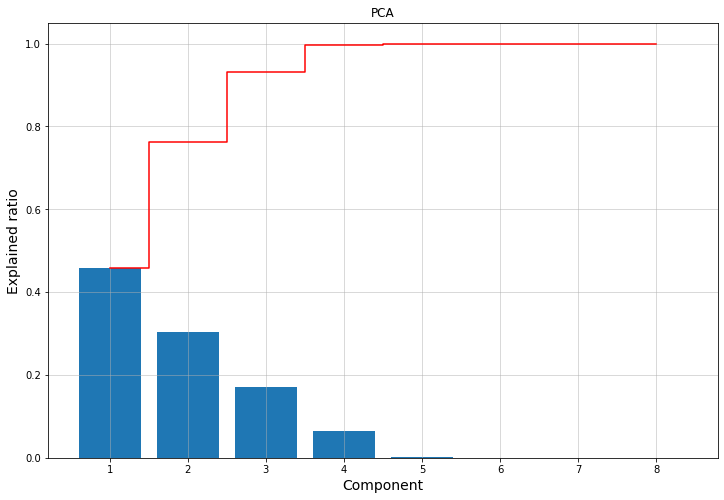

Components ratio: [4.57294449e-01 3.04760964e-01 1.70388690e-01 6.51872143e-02
 2.11180636e-03 1.74939654e-04 5.74312244e-05 2.45056579e-05]
Components ratio cumsum: [0.45729445 0.76205541 0.9324441  0.99763132 0.99974312 0.99991806
 0.99997549 1.        ]
3 komponenty objaśniają 94% zbioru!


In [8]:
plt.figure(figsize=(12,8))

plt.bar(range(1,9), pca.explained_variance_ratio_)
plt.step(range(1,9), np.cumsum(pca.explained_variance_ratio_), where='mid', color='red')

plt.title('PCA')

plt.xlabel('Component', fontsize=14)
plt.ylabel('Explained ratio', fontsize=14)

plt.grid(alpha=0.6)
plt.show()

print(f'Components ratio: {pca.explained_variance_ratio_}')
print(f'Components ratio cumsum: {np.cumsum(pca.explained_variance_ratio_)}')
print('3 komponenty objaśniają 94% zbioru!')

### SVC

In [16]:
from sklearn.svm import SVC

value_param = [0.01, 0.1, 1.0, 10, 100, 1000]

svc_pipe = make_pipeline(StandardScaler(), PCA(n_components=3), SVC())

svc_param_grid = [{'svc__C': value_param,
                  'svc__gamma': value_param,
                  'svc__class_weight': class_weight}]

svc_gs = GridSearchCV(estimator=svc_pipe, 
                       param_grid=svc_param_grid, scoring='balanced_accuracy', 
                       cv=10, n_jobs=-1)

In [ ]:
X = .....
X = PCA(n_components=3).fit_transform(X)

In [17]:
start_time = time()

svc_gs = svc_gs.fit(X_train, y_train)

print(f'Support Vector Machine training time {time() - start_time}.')
print(f'Wydajnosc {high_score(svc_gs, X_test, y_test)}')
print(f'Decision tree best params {svc_gs.best_params_}')

Support Vector Machine training time 2.4961609840393066.
signal count: 115
signal predict: 64
4368
4885
64
517.0000000000001
Wydajnosc 2.6551674036640716
Decision tree best params {'svc__C': 1000, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01}


In [18]:
print(f'Wydajnosc {high_score(svc_gs, X_test, y_test)}')

signal count: 115
signal predict: 64
4368
4885
64
517.0000000000001
Wydajnosc 2.6551674036640716


### Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression

lr_pipe = make_pipeline(StandardScaler(), PCA(n_components=3), LogisticRegression(max_iter=200, n_jobs=-1))

lr_param_grid = [{'logisticregression__C': value_param,
                 'logisticregression__class_weight': class_weight,
                 'logisticregression__solver': ['saga', 'lbfgs']}]

lr_gs = GridSearchCV(estimator=lr_pipe, param_grid=lr_param_grid, scoring='accuracy',
                    cv=10, n_jobs=-1)

In [96]:
start_time = time()

lr_gs = lr_gs.fit(X_train, y_train)

print(f'Logisti Regression training time {time() - start_time}.')
print(f'Wydajnosc {high_score(lr_gs, X_test, y_test)}')
print(f'Logistic Regression best params {lr_gs.best_params_}')

Logisti Regression training time 9.075731992721558.
110
0
4890
4890
0
0.0
Wydajnosc nan
Logistic Regression best params {'logisticregression__C': 0.01, 'logisticregression__class_weight': None, 'logisticregression__solver': 'saga'}


<ipython-input-91-b50b634fd6ad>:37: RuntimeWarning: invalid value encountered in double_scalars
  return S/np.sqrt(S+B)
